# Vechile Speed Estimation using Dashcam Data

This is a challenge programming project created by comma.ai. The data set is provided by them.

### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.1


### Model blueprin and compilation

In [7]:
def immo_part_model(normed_immo_signal):
    model = keras.Sequential([
        normed_immo_signal,
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
    ])
    return model

def full_model_compile(r_immo_signal, c_immo_signal, spped_target):
    r_immo_part_model = immo_part_model(r_immo_signal)
    c_immo_part_model = immo_part_model(c_immo_signal)
    
    concatenated_layer = tf.keras.layers.concatenate([r_immo_part_model, c_immo_part_model], axis=1)
    
    full_model = keras.Sequential([
        concatenated_layer,
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1),
    ])
    
    full_model.compile(loss='mean_squared_error',
                       optimizer=tf.keras.optimizers.Adam(0.001))
    return full_model

### Main loop for training

In [8]:
c_diff_kernel = np.array(
    [
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1],
    ]
)

r_diff_kernel = np.array(
    [
        [-1, -1, -1],
        [0, 0, 0],
        [1, 1, 1],
    ]
)

In [9]:
def immo_transform(frame):
    blur_kernel_size = (5, 5)
    blur_frame = cv2.GaussianBlur(frame, blur_kernel_size, 0)

    r_diff_frame = cv2.filter2D(blur_frame, -1, r_diff_kernel)
    c_diff_frame = cv2.filter2D(blur_frame, -1, c_diff_kernel)

    r_diff_frame = np.abs(np.sum(r_diff_frame, axis=1).reshape((1, -1)))
    c_diff_frame = np.abs(np.sum(c_diff_frame, axis=0).reshape((1, -1)))

    # these values are not normalized and is expected by model to normalize.
    return r_diff_frame, c_diff_frame


28.105569


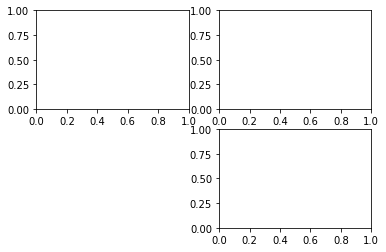

In [10]:
# matplotlib inits\
plt.set_cmap("gray")
r_immo_ax = plt.subplot(2, 2, 1)
img_ax = plt.subplot(2, 2, 2)
c_immo_ax = plt.subplot(2, 2, 4)


path_video="data/train.mp4"
path_target="data/train.txt"

video_obj = cv2.VideoCapture(path_video)
target_obj = open(path_target)


if not video_obj.isOpened() or not target_obj:
    print("Error opening file")
    exit(1)


# first frame
ret, prev_frame = video_obj.read()
prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
r_immo_prev, c_immo_prev = immo_transform(prev_frame)

# first spped target
speed = float(target_obj.readline())

r_norm = preprocessing.Normalization()
c_norm = preprocessing.Normalization()

# while video_obj.isOpened():
#     ret, curr_frame = video_obj.read()
#     # plt.clf()
#     if ret:
#         curr_frame = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
#         r_immo_curr, c_immo_curr = immo_transform(curr_frame)

#         # do processing / training
#         r_immo = np.concatenate((r_immo_prev, r_immo_curr),
#                                 axis=0).reshape((1, -1), order='F')
#         c_immo = np.concatenate((c_immo_prev, c_immo_curr),
#                                 axis=0).reshape((1, -1), order='F')

#         print(r_immo.shape, c_immo.shape)
#         # Actual training process

#         r_norm.adapt(r_immo)
#         c_norm.adapt(c_immo)

#         train(r_immo, c_immo, speed)

#         # swapping prev with current data
#         prev_frame, r_immo_prev, c_immo_prev = curr_frame, r_immo_curr, c_immo_curr
#     else:
#         continue

# plt.show()
# video_obj.release()
